In [1]:
#Import data manipulation libaries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



In [2]:
#Plotting
import base64
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import gc


# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

#### First data loading strategy

In [3]:
train_import = pd.read_csv("/kaggle/input/playground-series-s3e11/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s3e11/test.csv")
submission = pd.read_csv("/kaggle/input/playground-series-s3e11/sample_submission.csv")

In [4]:
train_import.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360336 entries, 0 to 360335
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          360336 non-null  int64  
 1   store_sales(in millions)    360336 non-null  float64
 2   unit_sales(in millions)     360336 non-null  float64
 3   total_children              360336 non-null  float64
 4   num_children_at_home        360336 non-null  float64
 5   avg_cars_at home(approx).1  360336 non-null  float64
 6   gross_weight                360336 non-null  float64
 7   recyclable_package          360336 non-null  float64
 8   low_fat                     360336 non-null  float64
 9   units_per_case              360336 non-null  float64
 10  store_sqft                  360336 non-null  float64
 11  coffee_bar                  360336 non-null  float64
 12  video_store                 360336 non-null  float64
 13  salad_bar     

### Binary data

In [5]:
train_bin = pd.read_csv("/kaggle/input/playground-series-s3e12/train.csv")
test_bin = pd.read_csv("/kaggle/input/playground-series-s3e12/test.csv")
submission_bin = pd.read_csv("/kaggle/input/playground-series-s3e12/sample_submission.csv")

In [37]:
train_bin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       414 non-null    int64  
 1   gravity  414 non-null    float64
 2   ph       414 non-null    float64
 3   osmo     414 non-null    int64  
 4   cond     414 non-null    float64
 5   urea     414 non-null    int64  
 6   calc     414 non-null    float64
 7   target   414 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 26.0 KB


#### Second data loading strategy
Loading another training data set
Adding a flag for the adversial cross-validation

In [6]:
test = pd.read_csv('/kaggle/input/playground-series-s3e6/test.csv')
test.drop("id",axis=1,inplace=True)
test['adv_val'] =  0

train = pd.read_csv('/kaggle/input/playground-series-s3e6/train.csv')
train.drop("id",axis=1,inplace=True)
train['adv_val'] =  1

original = pd.read_csv('/kaggle/input/paris-housing-price-prediction/ParisHousing.csv')
original['adv_val'] =  2

sample = pd.read_csv('/kaggle/input/playground-series-s3e6/sample_submission.csv')

In [7]:
sets={'train':train,'test':test,'original':original}

In [8]:
#Define the target label
target='price'

In [9]:
original.head(2)

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,adv_val
0,75523,3,0,1,63,9373,3,8,2005,0,1,4313,9005,956,0,7,7559081.5,2
1,80771,39,1,1,98,39381,8,6,2015,1,0,3653,2436,128,1,2,8085989.5,2


### Feature Distribution - Univariate

In [10]:
#########################################################################
### The function for data distribution analysis between two datasets  ###
#########################################################################

def viz_comp (data1,data2,title):
    n_bins = 50
    histplot_hyperparams = {
        'kde':True,
        'alpha':0.4,
        'stat':'percent',
        'bins':n_bins
    }
    cols=num_cols
    fig, ax = plt.subplots(len(cols)//3+1,3, figsize=(20, 20))
    ax = ax.flatten()

    for i, column in enumerate(cols):
        sns.histplot(
            data1[column], label='Train',
            ax=ax[i], color='green', **histplot_hyperparams)

    for i, column in enumerate(cols):
        sns.histplot(
            data2[column], label='Train',
            ax=ax[i], color='red', **histplot_hyperparams)
    ax[0].set_title(title, fontstyle='normal',size=25)

In [11]:
def miss_values_check(data,n):
    print(f'\033[0;33;40m A number of NaN values in {n} is {data.isnull().sum().sum()} \033[0;30;0m')
    if data.isnull().sum().sum() >0:
        sns.heatmap(data.isnull())
for n in sets:
    miss_values_check(sets[n],n)

 A number of NaN values in train is 0 
 A number of NaN values in test is 0 
 A number of NaN values in original is 0 


In [12]:
def create_EDA_summary (df = None):
    train_import_table = pd.DataFrame()
    train_import_table["dtype"] = df.apply(lambda x: x.dtype)
    train_import_table["NROW"] = df.shape[0]
    train_import_table["Unique_values"] = [ len(df[col].unique()) for col in df.columns]
    train_import_table["Percent_missing"] = (df.isnull().sum()/df.shape[0])*100
    
    return train_import_table

In [13]:
create_EDA_summary(train)

,dtype,NROW,Unique_values,Percent_missing
squareMeters,int64,22730,7319,0.0
numberOfRooms,int64,22730,100,0.0
hasYard,int64,22730,2,0.0
hasPool,int64,22730,2,0.0
floors,int64,22730,101,0.0
cityCode,int64,22730,7810,0.0
cityPartRange,int64,22730,10,0.0
numPrevOwners,int64,22730,10,0.0
made,int64,22730,33,0.0
isNewBuilt,int64,22730,2,0.0


#### Adversarial cross-validation

In [14]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score

In [15]:
from sklearn.utils import shuffle

def adv_validation (data_1,data_2,key):
    X_temp=shuffle(pd.concat([data_1,data_2],ignore_index=True))
    if key == True:
        adv_list = ['adv_val']
    else:
        adv_list = ['adv_val',target]
        
    X_full=X_temp.drop(adv_list,axis=1)
    y_full=X_temp.adv_val
    X_full,y_full=shuffle(X_full,y_full)
    X_full=X_full.reset_index(drop=True)
    y_full=y_full.reset_index(drop=True)
    result = cross_val_score(lgb.LGBMClassifier(n_estimators=200),X_full,y_full,scoring='roc_auc',cv=5).mean()
    return result

In [16]:
sets_adv_val={'train':train,'original':original}
for one in sets_adv_val:
    print (f'\033[0;33;40m Result between {one} and test = {adv_validation(sets_adv_val[one],test,False)} \033[0;30;0m')

 Result between train and test = 0.50151395282146 
 Result between original and test = 0.8350380937681363 


#### Permutation Importance

In [17]:
import eli5
from eli5.sklearn import PermutationImportance
##############################
### Permutation importance ###
##############################

def permutation_importance(model,X,y):
    permute = PermutationImportance(model,random_state=2023,n_iter =10,cv=5).fit(X, y)
    eli5.show_weights(permute, feature_names = X.columns.tolist(),top=50)
    values = dict(zip(list(train.columns),list(permute.feature_importances_)))
    sorted_dict = {}
    sorted_keys = sorted(values, key=values.get)
    for w in sorted_keys:
        sorted_dict[w] = values[w]

In [18]:
# Permuation Importance with LGBM
model = lgb.LGBMClassifier(n_estimators=100)
X=shuffle(pd.concat([original,test],ignore_index=True).drop(['adv_val',target],axis=1),random_state=2023).reset_index(drop=True)
y=shuffle(pd.concat([original,test],ignore_index=True).adv_val,random_state=2023).reset_index(drop=True)
metric='roc_auc'
permute = PermutationImportance(model,random_state=2023,n_iter =10,cv=5,scoring = metric).fit(X, y)
eli5.show_weights(permute, feature_names = X.columns.tolist(),top=50)

Weight,Feature
0.1586 ± 0.0118,made
0.0593 ± 0.0060,numberOfRooms
0.0437 ± 0.0061,floors
0.0304 ± 0.0049,squareMeters
0.0249 ± 0.0067,garage
0.0176 ± 0.0040,basement
0.0065 ± 0.0019,hasGuestRoom
0.0064 ± 0.0026,attic
0.0032 ± 0.0028,numPrevOwners
0.0026 ± 0.0018,cityPartRange


In [19]:
#Permuation Importance with LGBM Regressor
model = lgb.LGBMRegressor(n_estimators=100)
X=shuffle(pd.concat([train]).drop(['adv_val',target],axis=1),random_state=2023).reset_index(drop=True)
y=shuffle(pd.concat([train]).price,random_state=2023).reset_index(drop=True)
metric = 'neg_root_mean_squared_error'
permute = PermutationImportance(model,random_state=2023,n_iter =10,cv=5,scoring=metric).fit(X=X, y=y)
eli5.show_weights(permute, feature_names = X.columns.tolist(),top=50)

Weight,Feature
3952739.1821 ± 86241.3287,squareMeters
29465.8477 ± 45577.4245,cityCode
2661.9336 ± 4713.6106,made
1079.3959 ± 3196.0510,garage
891.6234 ± 3081.1440,hasStorageRoom
460.3366 ± 2734.3213,numberOfRooms
449.6146 ± 1726.1239,numPrevOwners
212.8277 ± 913.6594,cityPartRange
92.6407 ± 1468.8023,basement
24.8630 ± 377.3827,hasYard


In [20]:
adv_final = adv_validation(train[['squareMeters','adv_val','price']],
                           test[['squareMeters','adv_val']],
                           False)
print (f'\033[0;33;40m Result between train and test = {adv_final} \033[0;30;0m')

 Result between train and test = 0.5017851106626723 


In [21]:
adv_final = adv_validation(train[['squareMeters','price','adv_val']],
                           original[['squareMeters','price','adv_val']],
                           True)
print (f'\033[0;33;40m Result between train and original = {adv_final} \033[0;30;0m')

 Result between train and original = 0.5279467993840739 


In [22]:
#Combine train and priginbal data after the adversarial cross-validation
train=pd.concat([train,original],ignore_index=True)

In [23]:
#Drop the adversarial column
train=train.drop('adv_val',axis=1)
test=test.drop('adv_val',axis=1)
original=original.drop('adv_val',axis=1)

In [24]:
X = train.drop([target],axis=1)
y = train[target]
X,y=shuffle(X,y,random_state=2023)
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

In [25]:
X.shape

(32730, 16)

squareMeters
 Rejection 1 points  


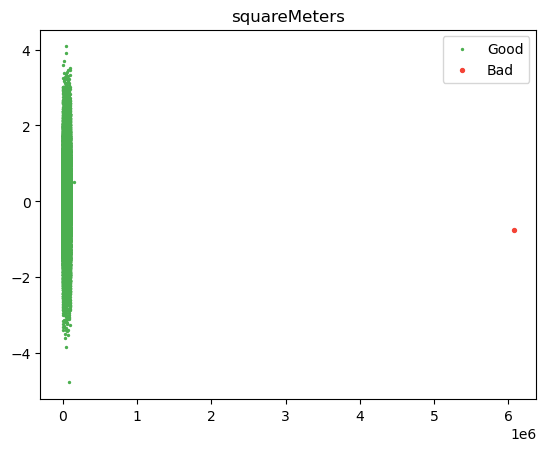

In [26]:
##########################################
### It is the most valnurable features ###
##########################################
num_cols_outl=['squareMeters']

from sklearn.neighbors import LocalOutlierFactor
cont_FEATURES = num_cols_outl

def plot_outliers(data,target,df, feature, threshold=8):
    mean, std = np.mean(df), np.std(df)
    z_score = np.abs((df-mean) / std)
    good = z_score < threshold
    print(f"\033[0;33;40m Rejection {(~good).sum()} points \033[0;30;0m ")
    visual_scatter = np.random.normal(size=df.size)
    plt.scatter(df[good], visual_scatter[good], s=2, label="Good", color="#4CAF50")
    plt.scatter(df[~good], visual_scatter[~good], s=8, label="Bad", color="#F44336")
    plt.legend(loc='upper right')
    plt.title(feature)
    plt.show();
    data,target = data[good],target[good]
    return data,target

for feature in cont_FEATURES:
    print(feature)
    X,y = plot_outliers(X,y,X[feature], feature)

In [27]:
create_EDA_summary(train_import)

,dtype,NROW,Unique_values,Percent_missing
id,int64,360336,360336,0.0
store_sales(in millions),float64,360336,1044,0.0
unit_sales(in millions),float64,360336,6,0.0
total_children,float64,360336,6,0.0
num_children_at_home,float64,360336,6,0.0
avg_cars_at home(approx).1,float64,360336,5,0.0
gross_weight,float64,360336,384,0.0
recyclable_package,float64,360336,2,0.0
low_fat,float64,360336,2,0.0
units_per_case,float64,360336,36,0.0


#### Heatmap

In [28]:
def heatmap(df = None):
    plt.figure(figsize=(18, 8))
    mask = np.triu(np.ones_like(df.corr()))
    sns.heatmap(df.corr(),cmap='YlOrRd',annot=True,mask=mask)

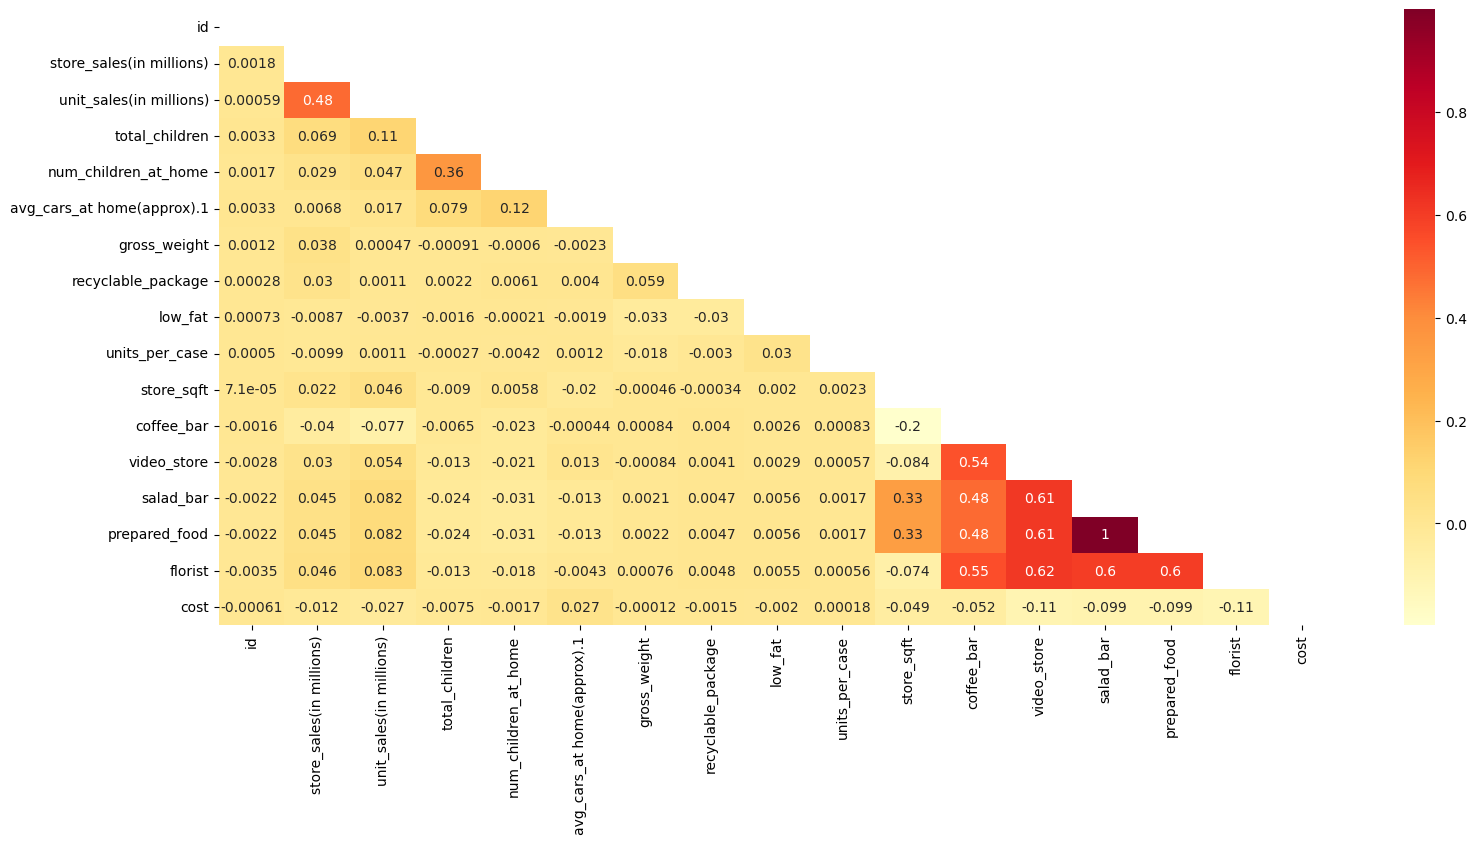

In [29]:
heatmap(train_import)

In [30]:
def univariate(train = None, test = None):
    n_cols = 3
    n_rows = (len(test.columns) - 1) // n_cols + 1

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 10))

    for i, var_name in enumerate(test.columns.tolist()):
        row = i // n_cols
        col = i % n_cols

        ax = axes[row, col]
        sns.distplot(train[var_name], kde=True, ax=ax, label='Train')
        sns.distplot(test[var_name], kde=True, ax=ax, label='Test')
        #sns.distplot(original[var_name], kde=True, ax=ax, label='Original')
        ax.set_title(f'{var_name} Distribution (Train vs Test)')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

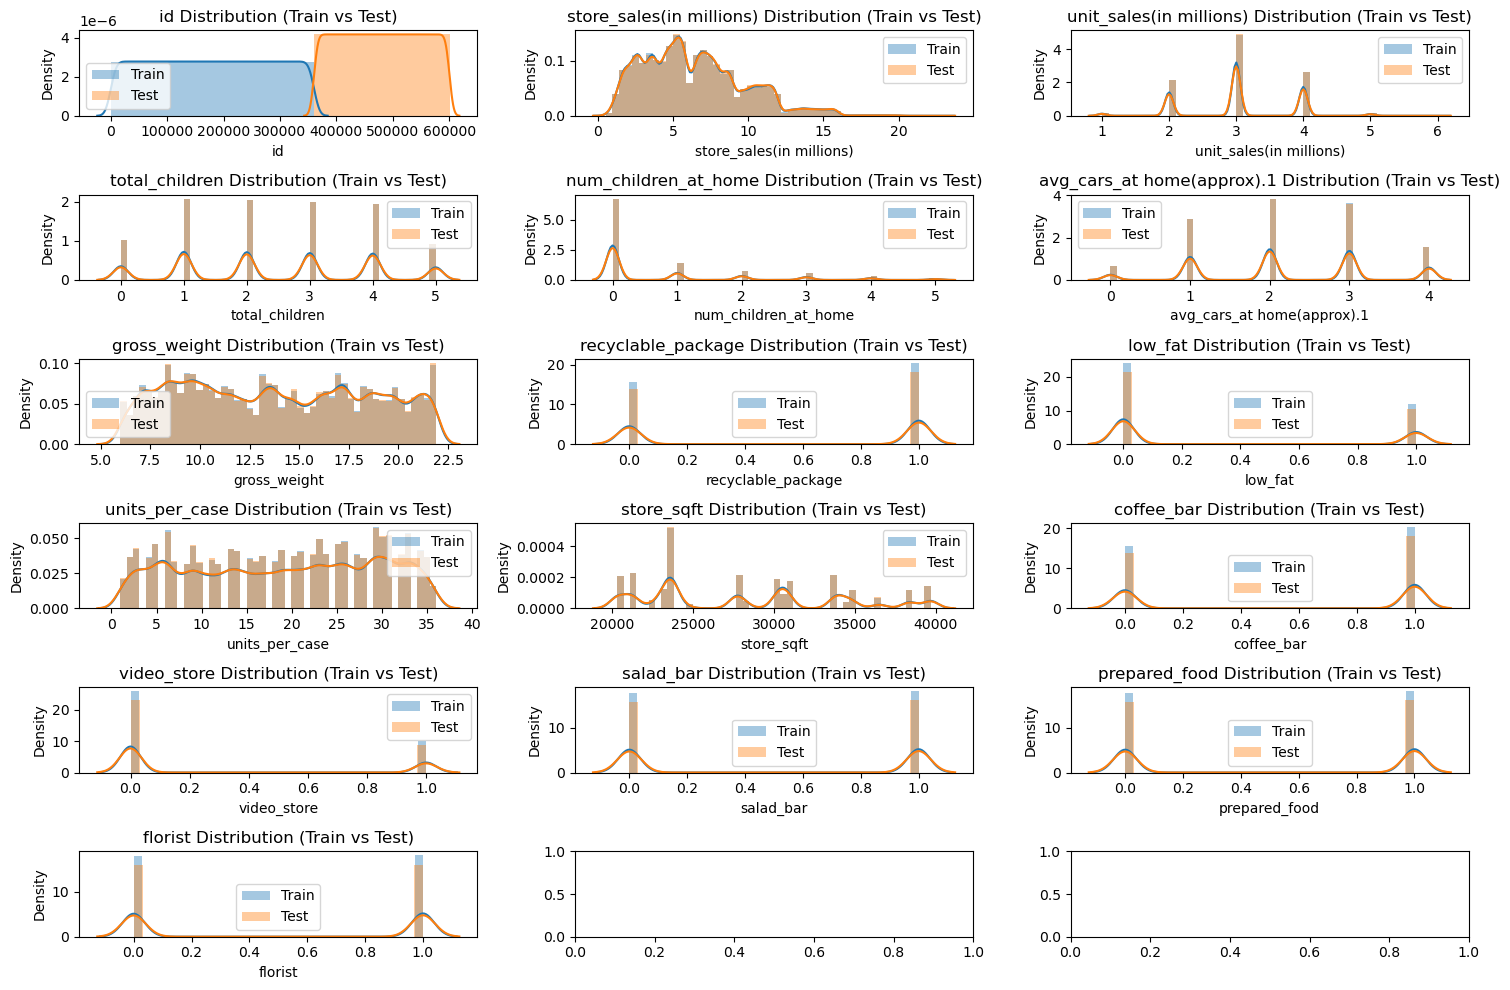

In [31]:
univariate(train_import, test_df)

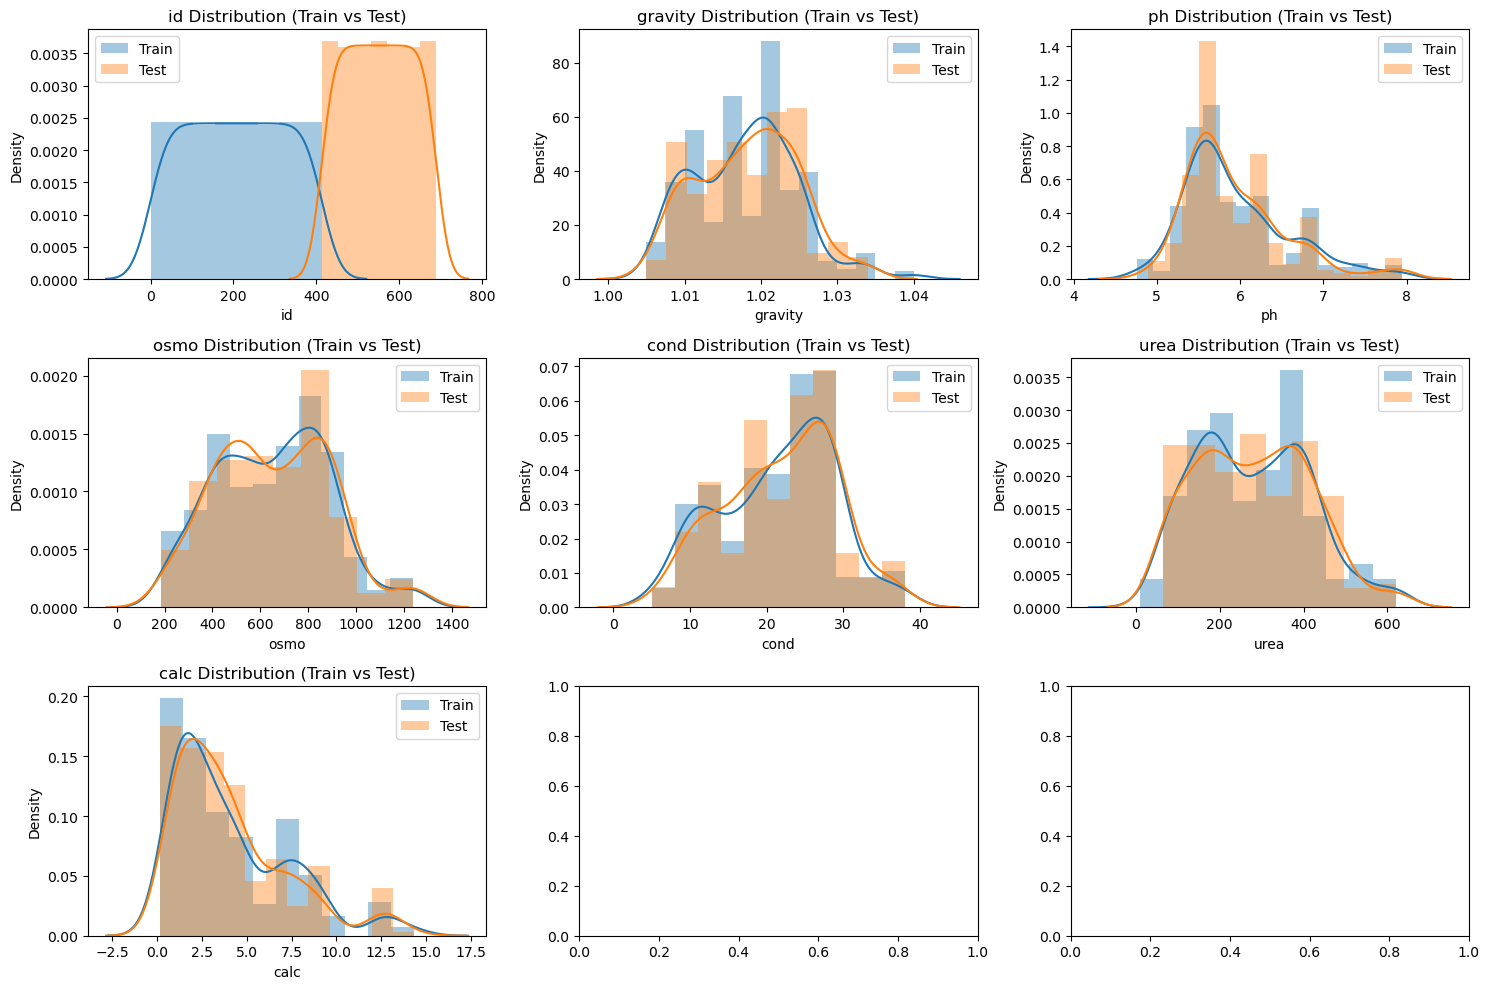

In [32]:
univariate(train_bin, test_bin)

In [33]:
train_import.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360336 entries, 0 to 360335
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          360336 non-null  int64  
 1   store_sales(in millions)    360336 non-null  float64
 2   unit_sales(in millions)     360336 non-null  float64
 3   total_children              360336 non-null  float64
 4   num_children_at_home        360336 non-null  float64
 5   avg_cars_at home(approx).1  360336 non-null  float64
 6   gross_weight                360336 non-null  float64
 7   recyclable_package          360336 non-null  float64
 8   low_fat                     360336 non-null  float64
 9   units_per_case              360336 non-null  float64
 10  store_sqft                  360336 non-null  float64
 11  coffee_bar                  360336 non-null  float64
 12  video_store                 360336 non-null  float64
 13  salad_bar     

In [34]:
def dist_by_target(train = None, test = None, target_col = ""):
    num_cols = 3
    num_rows = (len(test.columns) - 1) // num_cols
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(18, 4*num_rows))
    sns.set(font_scale=1.2, style='whitegrid')

    for i, col_name in enumerate(test.columns):
        if col_name != 'is_generated':
            ax = axes[i // num_cols, i % num_cols]
            sns.kdeplot(data=train, x=col_name, hue=target_col, ax=ax, fill=True, alpha=0.5, linewidth=2)

            # sns.kdeplot(data=original, x=col_name, hue=target_col, ax=ax, fill=True, alpha=0.5, linewidth=2)

            ax.set_title(f'{col_name.title()} Distribution by {target_col.title()}', fontsize=18)
            ax.set_xlabel(col_name.title(), fontsize=14)
            ax.set_ylabel(target_col.title(), fontsize=14)
            ax.tick_params(axis='both', which='major', labelsize=12)
            ax.legend([1, 0], title=target_col.title(), fontsize=12)

    plt.tight_layout()
    plt.show()

IndexError: index 2 is out of bounds for axis 0 with size 2

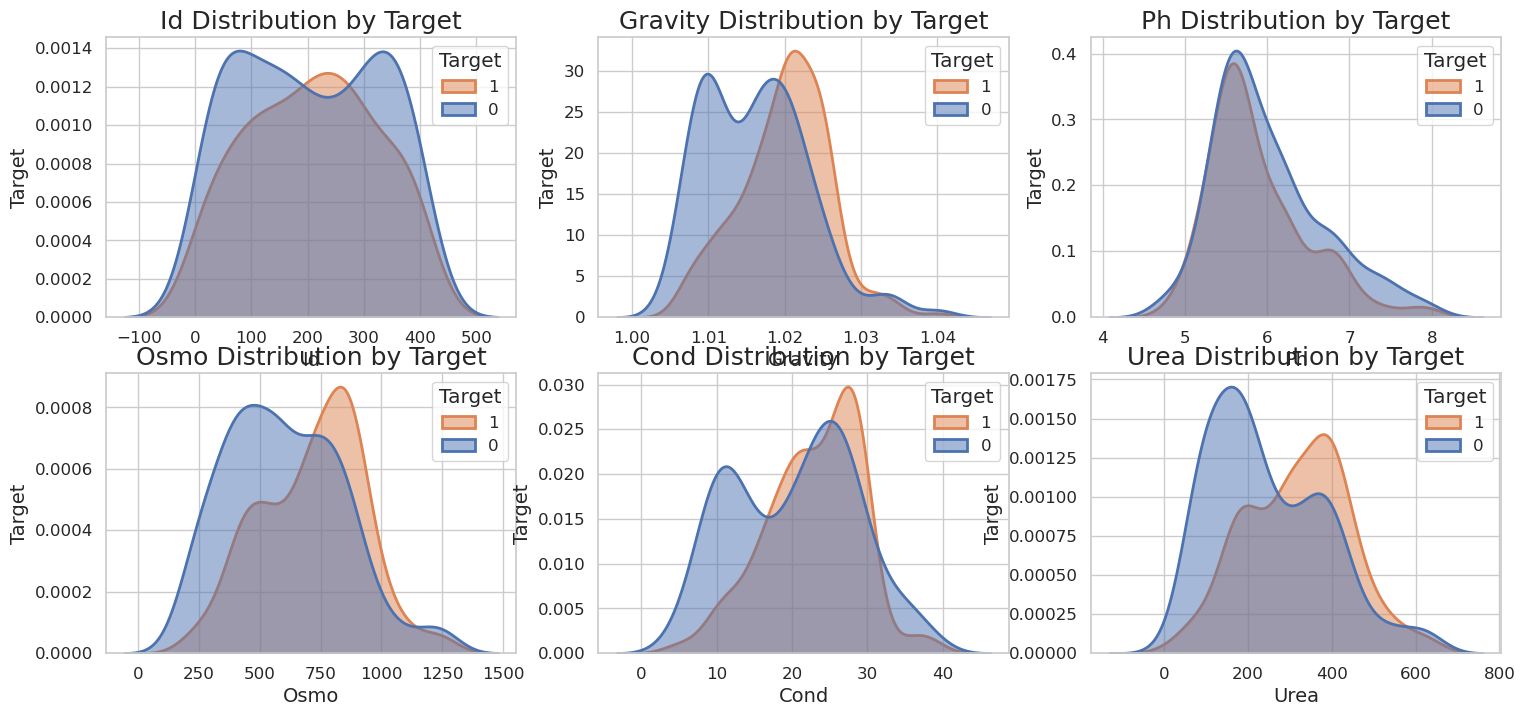

In [39]:
dist_by_target(train = train_bin, test = test_bin, target_col = "target")